# Guía 4 - Problema 2

## Red Erdös-Rényi

In [1]:
import random
random.seed(42)

In [2]:
# Primer caso 
N = 10000
p = 0.01

# Creamos lista de nodos
nodes = [i for i in range(N)]

# Ahora, para cada par de nodos (i,j) posible, evaluamos si hay que generar o no enlace. 
edges = []

for node_i in nodes:
    for node_j in range(node_i+1,N): # El +1 es para evitar enlaces de un nodo consigo mismo
        if random.random()<p:
            edges.append((node_i,node_j))

La red entonces está representada como una lista de enlaces, que mediante otros algoritmos puede utilizarse para construir las listas de vecinos, o la matriz de adyacencia.

El número de enlaces en la red, dividido el número máximo posible de enlaces que puede haber en un grafo de $N$ nodos, debería dar un valor cercano a $p$ (es una forma de chequear que nuestro algoritmo funciona bien).

In [16]:
from scipy.special import comb
len(edges)/comb(N,2)

0.009966996699669967

In [19]:
# Vamos a calcular el grado de los nodos del grafo generado
degrees = [ 0  for i in range(N)]
for edge in edges:
    i,j = edge
    degrees[i] += 1
    degrees[j] += 1

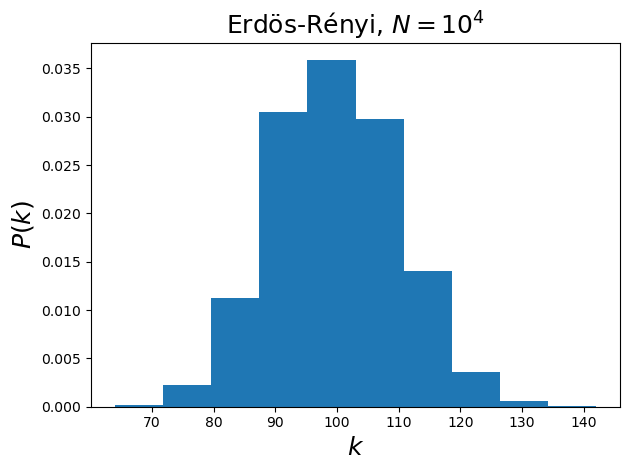

In [32]:
from matplotlib import pyplot as plt

plt.title('Erdös-Rényi, $N=10^4$',size=18)

plt.hist(degrees,bins=15,density=True)
plt.xlabel('$k$',size=18)
plt.ylabel('$P(k)$',size=18)

plt.tight_layout()

Para la red más grande de $N=10^5$ vamos a implementar una pequeña paralelización que nos va a agilizar un poco el trabajo con la librería `loky`. La librería `tqdm` nos permite agregar una barra de carga para ver el tiempo restante de ejecución de manera interactiva. 

In [33]:
from loky import ProcessPoolExecutor
from tqdm import tqdm

In [34]:
# Segundo caso
N = 100000
p = 0.001

# Creamos lista de nodos
nodes = [i for i in range(N)]

# Ahora, para cada par de nodos (i,j) posible, evaluamos si hay que generar o no enlace. 
edges = []

# Esta función evalúa cuántos nodos j están enlazados con un nodo i (0<i<N, i<j<N). De esta forma no hay enlaces repetidos.
def f(node_i):
    edges_i = []
    for node_j in range(node_i+1,N): 
        if random.random() < p:
            edges_i.append((node_i,node_j))
    return edges_i

with ProcessPoolExecutor() as e:
    edges = list(tqdm(e.map(f,nodes),total=len(nodes)))

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [02:54<00:00, 574.06it/s]


In [35]:
import numpy as np
edges = list(filter(None,edges)) # Eliminamos cualquier lista vacía que haya resultado de evaluar la función f sobre algún nodo
edges = np.concatenate(edges) # Concatenamos todos los enlaces en una única lista

In [36]:
edges[:10]

array([[    0,   835],
       [    0,  1023],
       [    0,  5288],
       [    0,  5727],
       [    0,  6973],
       [    0,  7786],
       [    0, 10726],
       [    0, 10887],
       [    0, 11308],
       [    0, 12388]])

In [38]:
# Chequeo
len(edges)/comb(N,2)

0.0009996419964199642

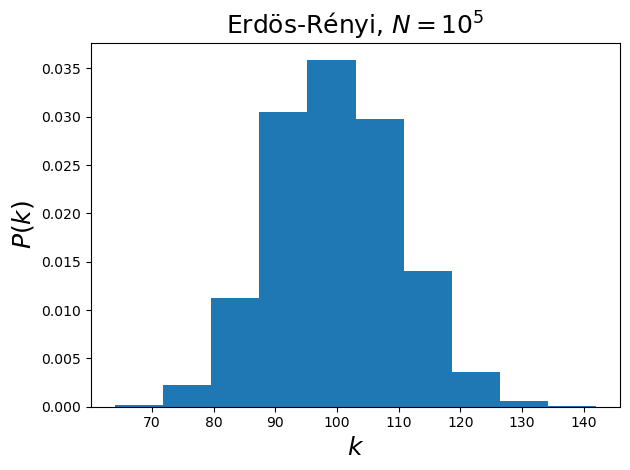

## Red Barabási-Albert

Por la forma en la que se construye la red en el modelo, es conveniente trabajar esta vez con las listas de vecinos para almacenar el grafo.

Vamos a empezar con un grafo aleatorio Erdös-Renyi, que cumpla con la condición pedida ($<k> = 4$). Eso se puede pedir eligiendo valores adecuados para los valores de $p$ y el número inicial de nodos en el grafo $n_0$. 

Estas variables están relacionadas mediante la siguiente ecuación: 

$$ <k> = n_0 p, $$ cuya validez es mayor a medida que $n_0\to\infty$.

Por lo tanto, vamos a elegir arbitrariamente $n_0 = N/2$, es decir que si esperamos al final un grafo de $N=10^4$ nodos, vamos a tener 5000 grafos inicialmente en el grafo aleatorio. Con esa elección, nos queda $p = \frac{2<k>}{N} = \frac{2\times 4}{10000} =0.0008$ 

In [57]:
# Primer caso
## Paso 1: Construcción del grafo aleatorio
n0 = 100
N = 10000
p = 0.0008

# Creamos lista de nodos
nodes = [i for i in range(n0)]

# Ahora, para cada par de nodos (i,j) posible, evaluamos si hay que generar o no enlace. 
edges = []

for node_i in nodes:
    for node_j in range(node_i+1,n0): # El +1 es para evitar enlaces de un nodo consigo mismo
        if random.random()<p:
            edges.append((node_i,node_j))

## Paso 2: Traducción de la lista de enlaces a lista de vecinos
neighbor_list = {}

for i in range(n0):
    neighbor_list[i] = []

for i,j in edges: 
    neighbor_list[i].append(j)
    neighbor_list[j].append(i)

# Calculemos cuál es el grado medio del grafo aleatorio (debería ser algo cercano a 4)
k = 0
for i in range(len(neighbor_list)):
    k += len(neighbor_list[i])

print('Mean degree:',k/n0)

## Tercer paso: Construcción de la red de Barabási-Albert
# Lo primero que tenemos que tener es una función que nos devuelva la probabilidad de que el nodo i sea elegido en el sorteo
def get_pi(neighbor_list):
    p = []
    k_total = sum(len(neighbor_list[i]) for i in range(len(neighbor_list)))
    for i in range(len(neighbor_list)):
        p.append(len(neighbor_list[i])/k_total)
    return p

random_state = np.random.RandomState(42)

# Lo segundo que tenemos que hacer es añadir nuevos nodos con m conexiones cada uno, hasta llegar a los N nodos
m = 4 
for i in range(n0,N):
    # Añadimos el nuevo nodo
    neighbor_list[i] = []
    # Sorteamos los m vecinos de este nuevo nodo con las probabilidades calculadas según la función get_pi
    new_neighbors = random_state.choice(list(neighbor_list.keys()),size=m,p=get_pi(neighbor_list))
    for new_neighbor in new_neighbors:
        neighbor_list[i].append(new_neighbor)
        neighbor_list[new_neighbor].append(i)

Mean degree: 0.08


In [58]:
degrees = [len(neighbors) for neighbors in list(neighbor_list.values())]

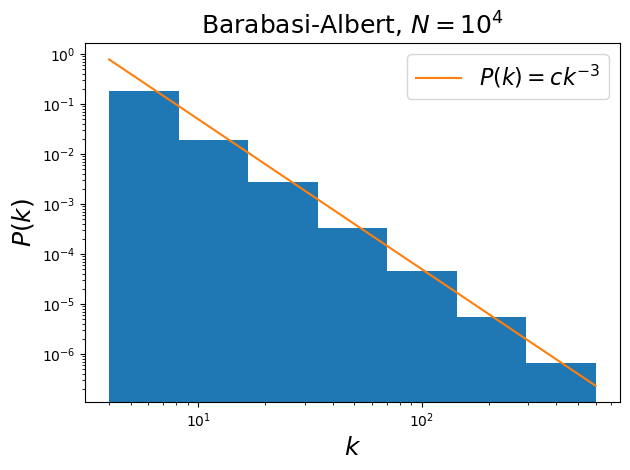

In [76]:
bins = np.logspace(np.log10(4),np.log10(600),8)

plt.title('Barabasi-Albert, $N=10^4$',size=18)

plt.hist(degrees,bins=bins,density=True)
plt.xlabel('$k$',size=18)
plt.ylabel('$P(k)$',size=18)
plt.xscale('log')
plt.yscale('log')
x = np.linspace(4,600,1000)
y = 50*x**(-3)
plt.plot(x,y,label='$P(k) = ck^{-3}$')

plt.legend(fontsize=16)

plt.tight_layout()

In [78]:
# Primer caso
## Paso 1: Construcción del grafo aleatorio
n0 = 1000
N = 100000
p = 0.00008

# Creamos lista de nodos
nodes = [i for i in range(n0)]

# Ahora, para cada par de nodos (i,j) posible, evaluamos si hay que generar o no enlace. 
edges = []

for node_i in nodes:
    for node_j in range(node_i+1,n0): # El +1 es para evitar enlaces de un nodo consigo mismo
        if random.random()<p:
            edges.append((node_i,node_j))

## Paso 2: Traducción de la lista de enlaces a lista de vecinos
neighbor_list = {}

for i in range(n0):
    neighbor_list[i] = []

for i,j in edges: 
    neighbor_list[i].append(j)
    neighbor_list[j].append(i)

# Calculemos cuál es el grado medio del grafo aleatorio (debería ser algo cercano a 4)
k = 0
for i in range(len(neighbor_list)):
    k += len(neighbor_list[i])

print('Mean degree:',k/n0)

## Tercer paso: Construcción de la red de Barabási-Albert
# Lo primero que tenemos que tener es una función que nos devuelva la probabilidad de que el nodo i sea elegido en el sorteo
def get_pi(neighbor_list):
    p = []
    k_total = sum(len(neighbor_list[i]) for i in range(len(neighbor_list)))
    for i in range(len(neighbor_list)):
        p.append(len(neighbor_list[i])/k_total)
    return p

random_state = np.random.RandomState(42)

# Lo segundo que tenemos que hacer es añadir nuevos nodos con m conexiones cada uno, hasta llegar a los N nodos
m = 4 
for i in range(n0,N):
    # Añadimos el nuevo nodo
    neighbor_list[i] = []
    # Sorteamos los m vecinos de este nuevo nodo con las probabilidades calculadas según la función get_pi
    new_neighbors = random_state.choice(list(neighbor_list.keys()),size=m,p=get_pi(neighbor_list))
    for new_neighbor in new_neighbors:
        neighbor_list[i].append(new_neighbor)
        neighbor_list[new_neighbor].append(i)
    if N%i == 0:
        print(i)

Mean degree: 0.072
1000
1250
2000
2500
3125
4000
5000
6250
10000
12500
20000
25000
50000


In [79]:
degrees = [len(neighbors) for neighbors in list(neighbor_list.values())]

In [80]:
max(degrees)

551

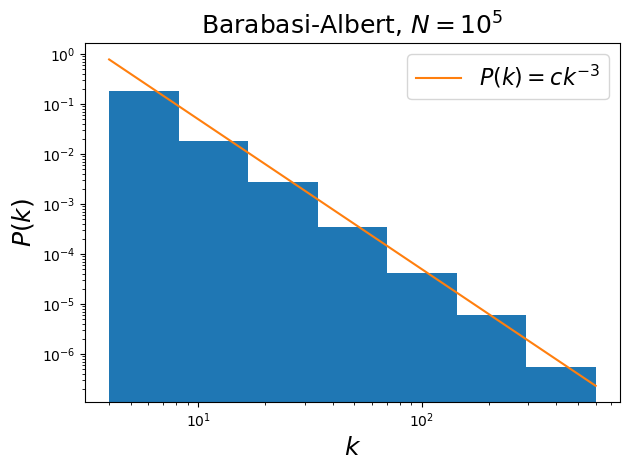

In [81]:
bins = np.logspace(np.log10(4),np.log10(600),8)

plt.title('Barabasi-Albert, $N=10^5$',size=18)

plt.hist(degrees,bins=bins,density=True)
plt.xlabel('$k$',size=18)
plt.ylabel('$P(k)$',size=18)
plt.xscale('log')
plt.yscale('log')
x = np.linspace(4,600,1000)
y = 50*x**(-3)
plt.plot(x,y,label='$P(k) = ck^{-3}$')

plt.legend(fontsize=16)

plt.tight_layout()

## Incisos

### (a) Visualización con $N=200$

Vamos a dibujar el grafo con un tamaño de nodos y escala de colores proporcionales al grado del nodo. Así vamos a poder identificar visualmente los _hubs_.

#### Erdös-Rényi

In [83]:
import networkx as nx
erdos_renyi = nx.erdos_renyi_graph(200,0.02)

In [84]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

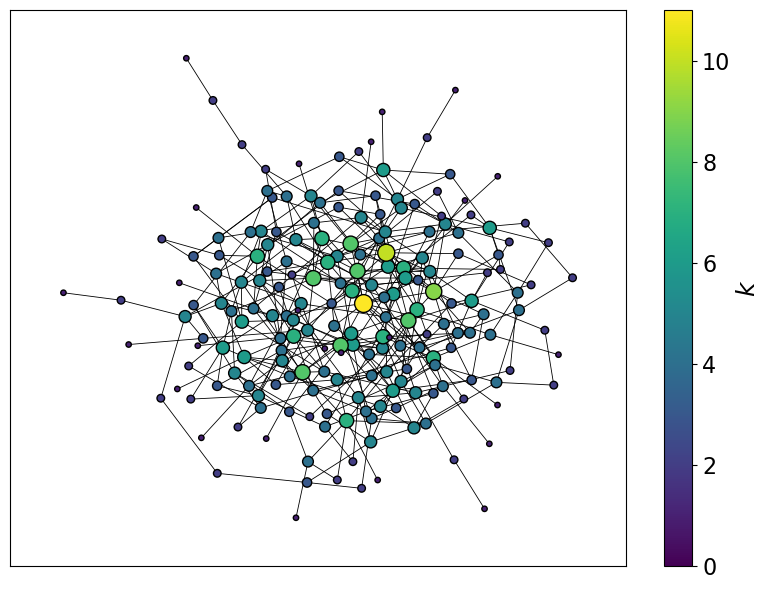

In [85]:
pos = nx.drawing.layout.kamada_kawai_layout(erdos_renyi)

degrees = erdos_renyi.degree() #Dict with Node ID, Degree
nodes = erdos_renyi.nodes()
n_color = np.asarray([degrees[n] for n in nodes])

edges = erdos_renyi.edges()

fig, ax = plt.subplots(figsize=(8,6))
sc = nx.draw_networkx_nodes(erdos_renyi,pos=pos,nodelist=nodes,node_color=n_color,
                      ax=ax,cmap='viridis',node_size=15*n_color,edgecolors='k')
nx.draw_networkx_edges(erdos_renyi,pos=pos,width=0.6,ax=ax)

cb = fig.colorbar(sc,)
cb.set_label('$k$',size=18)
cb.ax.tick_params(labelsize=16)
plt.tight_layout()

#### Barabási-Albert

In [86]:
barabasi = nx.barabasi_albert_graph(200,4)

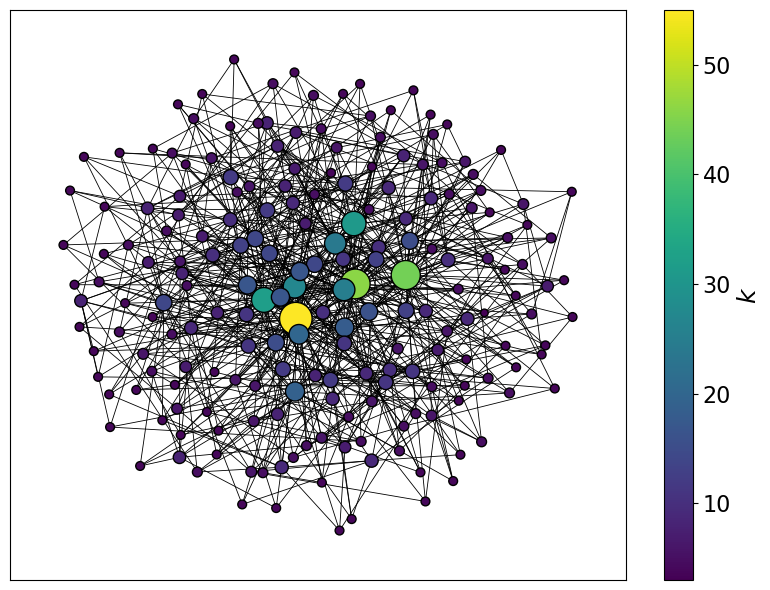

In [87]:
pos = nx.drawing.layout.kamada_kawai_layout(barabasi)

degrees = barabasi.degree() #Dict with Node ID, Degree
nodes = barabasi.nodes()
n_color = np.asarray([degrees[n] for n in nodes])

edges = barabasi.edges()

fig, ax = plt.subplots(figsize=(8,6))
sc = nx.draw_networkx_nodes(barabasi,pos=pos,nodelist=nodes,node_color=n_color,
                      ax=ax,cmap='viridis',node_size=10*n_color,edgecolors='k')
nx.draw_networkx_edges(barabasi,pos=pos,width=0.6,ax=ax)

cb = fig.colorbar(sc)
cb.set_label('$k$',size=18)
cb.ax.tick_params(labelsize=16)
plt.tight_layout()

### (b) Distribuciones de grado

#### Erdös-Rényi

In [88]:
degrees_er = [erdos_renyi.degree[i] for i in range(erdos_renyi.number_of_nodes())]

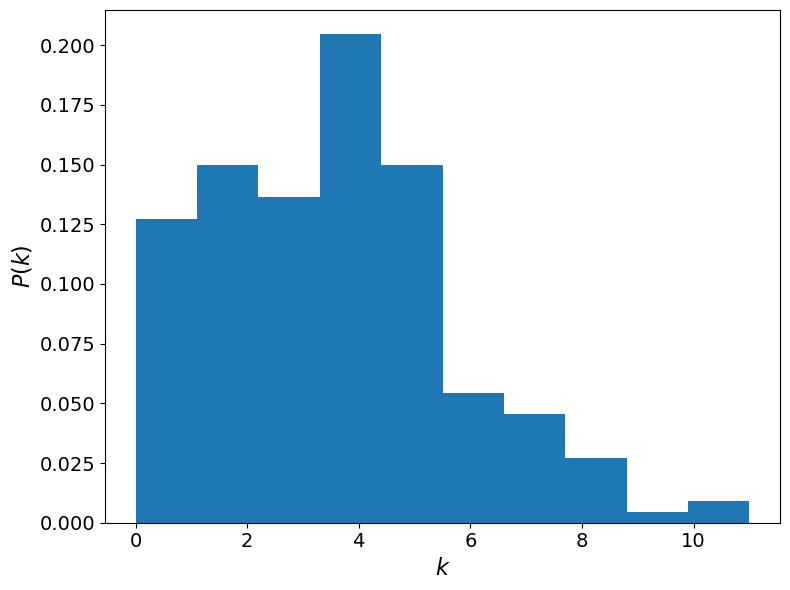

In [89]:
plt.figure(figsize=(8,6))
plt.hist(degrees_er,density=True,bins=10)
plt.xlabel('$k$',size=16)
plt.ylabel('$P(k)$',size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

#### Barabási-Albert

In [90]:
degrees_ba = [barabasi.degree[i] for i in range(barabasi.number_of_nodes())]

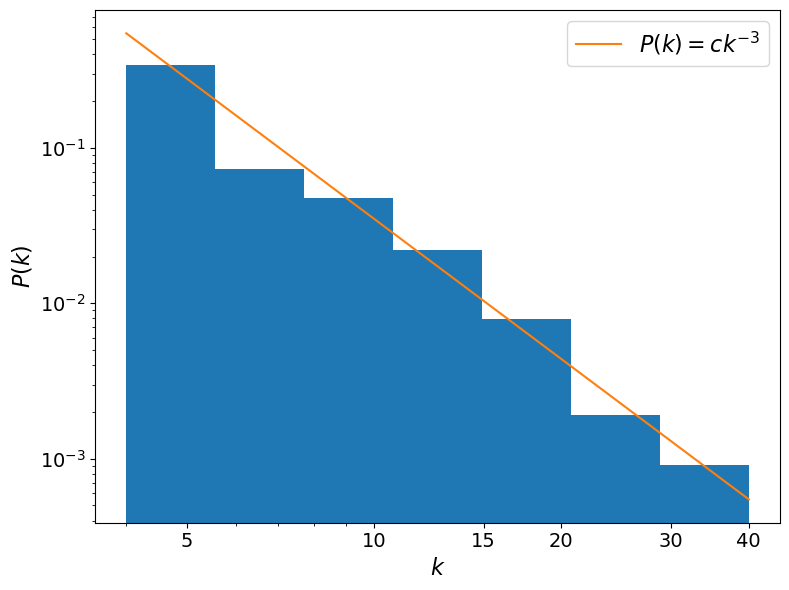

In [96]:
import matplotlib
fig,ax = plt.subplots(figsize=(8,6))
bins = np.logspace(np.log10(4),np.log10(40),8)

ax.hist(degrees_ba,bins=bins,density=True)
x = np.linspace(4,40,1000)
y = 35*x**(-3)
ax.plot(x,y,label='$P(k) = ck^{-3}$')

ax.set_xlabel('$k$',size=16)
ax.set_ylabel('$P(k)$',size=16)

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(fontsize=16)

ax.set_xticks([5,10,15,20,30,40])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.tick_params(axis='both',labelsize=14)

plt.tight_layout()

### (c) Distribución $k_{nn}$

#### Erdös-Rényi

In [97]:
def get_k_list(k_dist):
    k_list = []
    for k in range(max(k_dist)):
        k_i = []
        for j,k_j in enumerate(k_dist):
            if k_j==k:
                k_i.append(j)
        k_list.append(k_i)
    return k_list

def knn(k,k_dist,k_list,neighbors_list):
    if k==0: return 0
    nodes_k = k_list[k]
    if len(nodes_k)==0: return 0
    knn = 0
    for node in nodes_k:
        neighbors = neighbors_list[node]
        knn_i = 0
        for neighbor in neighbors:
            knn_i += k_dist[neighbor]
        knn_i /= k
        knn += knn_i
    knn /= len(nodes_k)
    return knn

In [98]:
degrees_er = [erdos_renyi.degree[i] for i in range(erdos_renyi.number_of_nodes())]
k_list_er = get_k_list(degrees_er)
neighbors_list_er = [erdos_renyi.neighbors(i) for i in range(erdos_renyi.number_of_nodes())]

In [99]:
knn_er = [knn(k,degrees_er,k_list_er,neighbors_list_er) for k in range(max(degrees_er))]

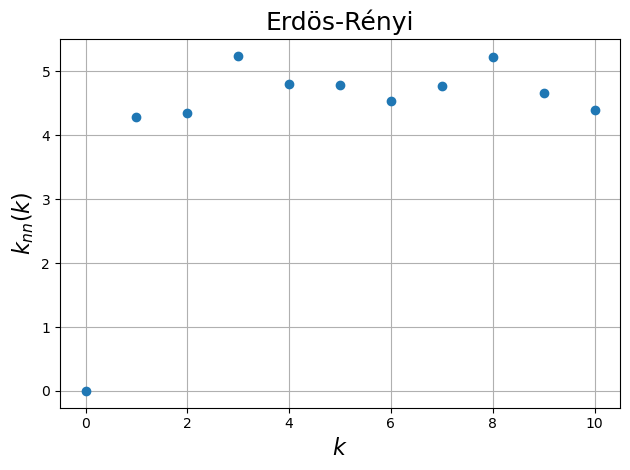

In [100]:
plt.title('Erdös-Rényi',size=18)
plt.plot(knn_er,'o',markersize=6)
plt.xlabel('$k$',size=16)
plt.ylabel('$k_{nn} (k)$',size=16)
plt.grid()
plt.tight_layout()
plt.show()

#### Barabasi

In [101]:
degrees_ba = [barabasi.degree[i] for i in range(barabasi.number_of_nodes())]
k_list_ba = get_k_list(degrees_ba)
neighbors_list_ba = [barabasi.neighbors(i) for i in range(barabasi.number_of_nodes())]

In [102]:
knn_ba = [knn(k,degrees_ba,k_list_ba,neighbors_list_ba) for k in range(max(degrees_ba))]

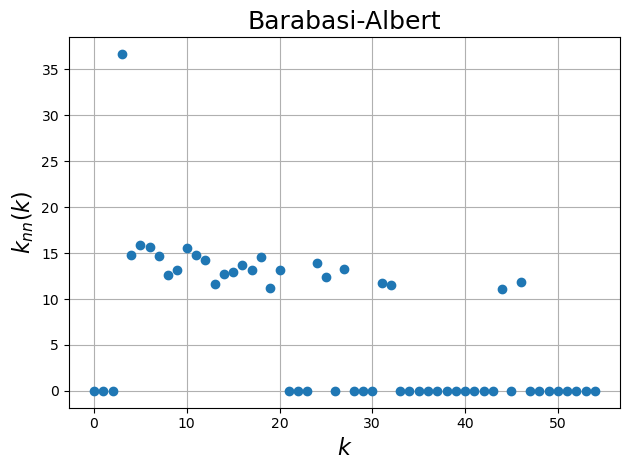

In [103]:
plt.title('Barabasi-Albert',size=18)
plt.plot(knn_ba,'o',markersize=6)
plt.xlabel('$k$',size=16)
plt.ylabel('$k_{nn} (k)$',size=16)
plt.grid()
plt.tight_layout()
plt.show()